# 0. Install and Import dependencies

In [43]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [75]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

In [93]:
# Specify parameters
STOCK_NAME = 'AMD'

# Window size for training
TRAIN_WINDOW_SIZE = 10
TRAIN_START = '2020-01-01'
TRAIN_END = '2022-12-31'

TEST_WINDOW_SIZE = 10

# Indicator parameters
SMA_PERIOD = 10

# 1. Get Data

In [94]:
import yfinance as yf

df = yf.Ticker(STOCK_NAME)
df = df.history(period="max")
df = df.loc[TRAIN_START:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1082, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,46.860001,49.250000,46.630001,49.099998,80331100
2020-01-03 00:00:00-05:00,48.029999,49.389999,47.540001,48.599998,73127400
2020-01-06 00:00:00-05:00,48.020000,48.860001,47.860001,48.389999,47934900
2020-01-07 00:00:00-05:00,49.349998,49.389999,48.040001,48.250000,58061400
2020-01-08 00:00:00-05:00,47.849998,48.299999,47.139999,47.830002,53767000


In [95]:
TRAIN_ENV_FRAME_BOUND = (TRAIN_WINDOW_SIZE, df[TRAIN_START:TRAIN_END].shape[0])
TEST_ENV_FRAME_BOUND = (df[TRAIN_START:TRAIN_END].shape[0], df.shape[0])

In [96]:
df[TRAIN_START:TRAIN_END]

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,46.860001,49.250000,46.630001,49.099998,80331100
2020-01-03 00:00:00-05:00,48.029999,49.389999,47.540001,48.599998,73127400
2020-01-06 00:00:00-05:00,48.020000,48.860001,47.860001,48.389999,47934900
2020-01-07 00:00:00-05:00,49.349998,49.389999,48.040001,48.250000,58061400
2020-01-08 00:00:00-05:00,47.849998,48.299999,47.139999,47.830002,53767000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,63.110001,64.660004,62.720001,64.519997,45923000
2022-12-27 00:00:00-05:00,63.869999,64.279999,62.970001,63.270000,36086000
2022-12-28 00:00:00-05:00,62.540001,63.540001,61.959999,62.570000,39526500


# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [97]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [98]:
df['SMA'] = TA.SMA(df, SMA_PERIOD)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [99]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [100]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [115]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [105]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [106]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=2023)
model.learn(total_timesteps=50)

# 4. Evaluation

In [108]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 46.84001541137695, 'total_profit': 0.5335067167771335, 'position': <Positions.Short: 0>}


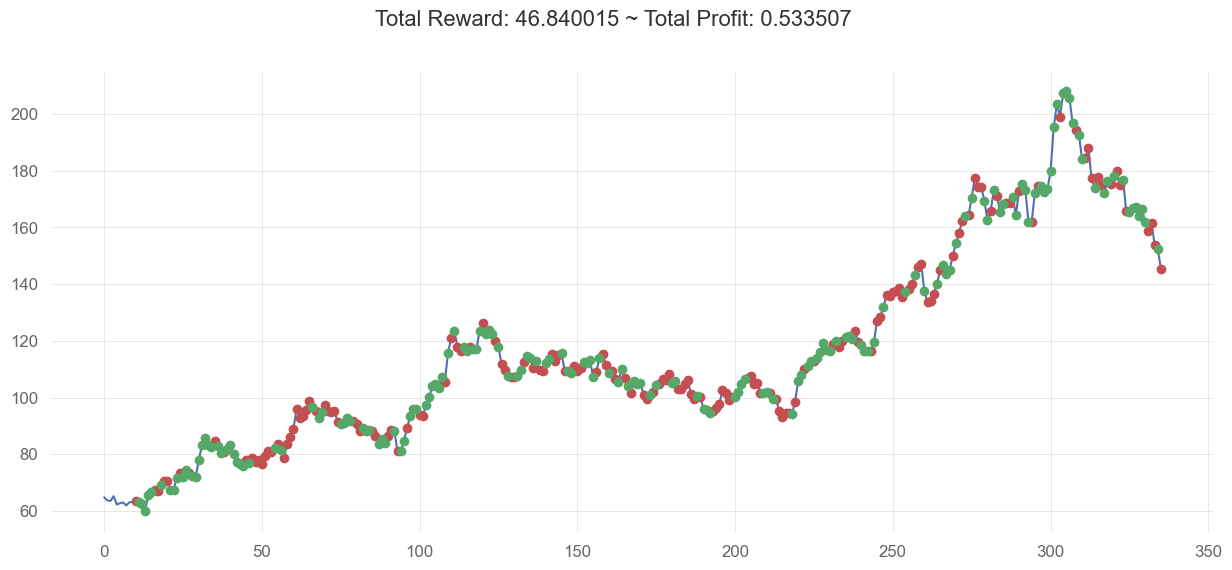

In [109]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-01-05
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -46.65%
CAGR﹪                     -28.6%

Sharpe                     -1.23
Prob. Sharpe Ratio         9.03%
Smart Sharpe               -1.23
Sortino                    -1.68
Smart Sortino              -1.67
Sortino/√2                 -1.19
Smart Sortino/√2           -1.18
Omega                      0.65

Max Drawdown               -59.14%
Longest DD Days            432
Volatility (ann.)          34.76%
Calmar                     -0.48
Skew                       0.84
Kurtosis                   14.18

Expected Daily %           -0.19%
Expected Monthly %         -3.85%
Expected Yearly %          -26.96%
Kelly Criterion            -22.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.77%
Expected Shortfall (cVaR)  -3.77%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-13,2024-04-19,2024-04-19,431,-59.136588,-53.952491


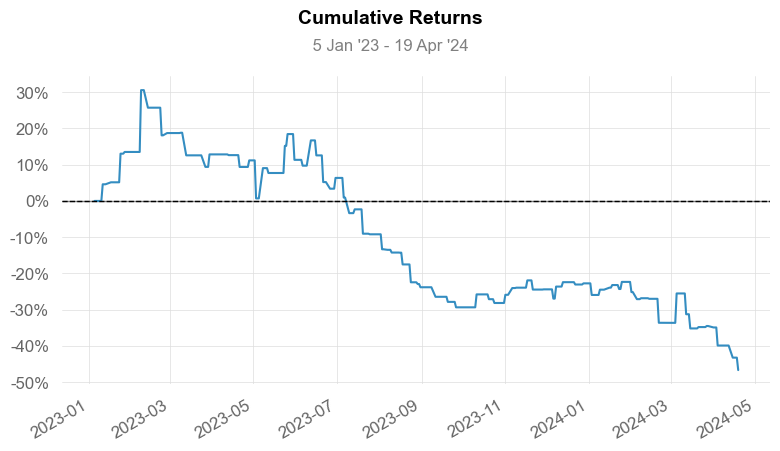

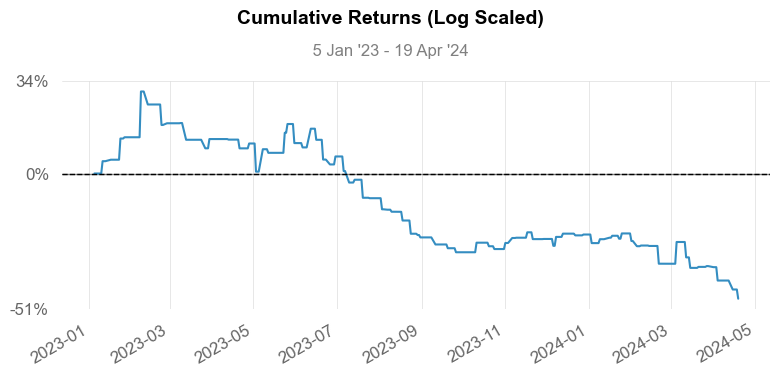

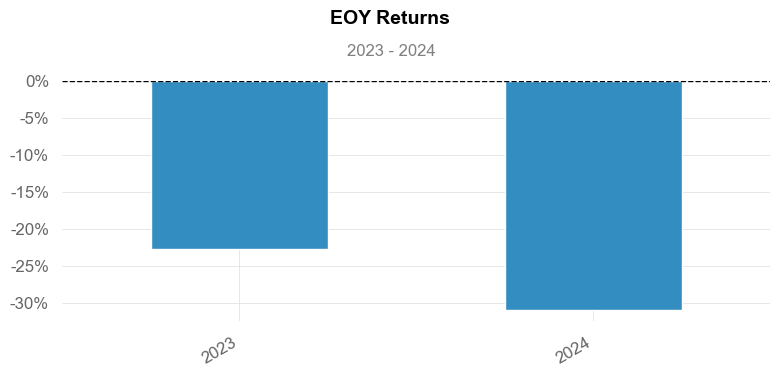

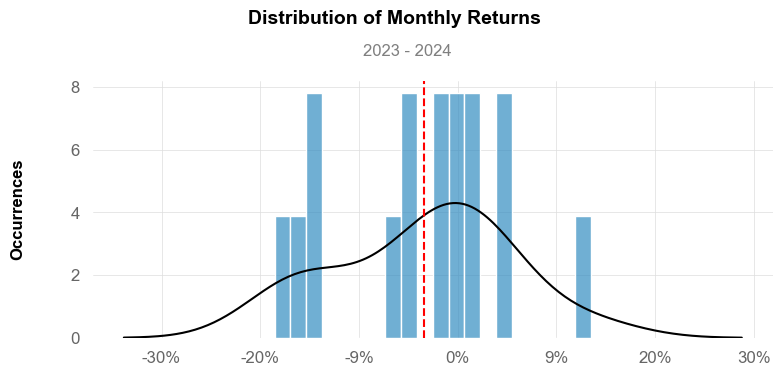

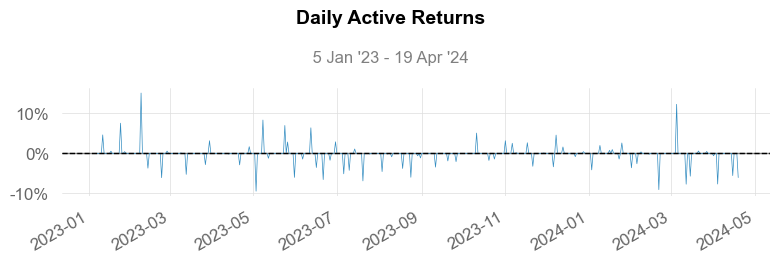

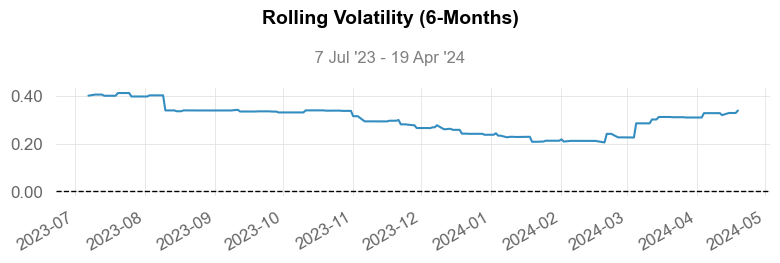

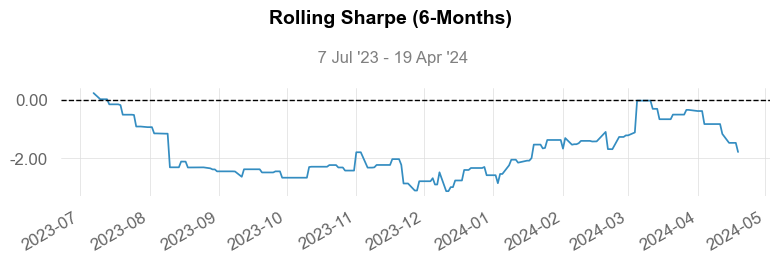

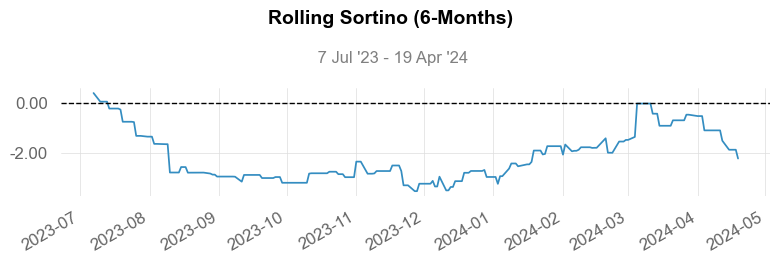

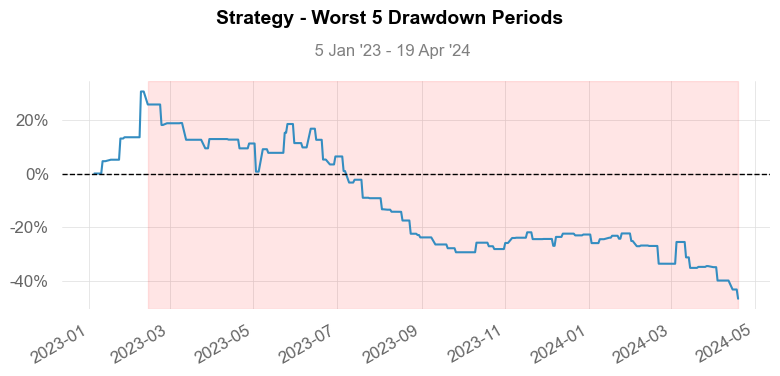

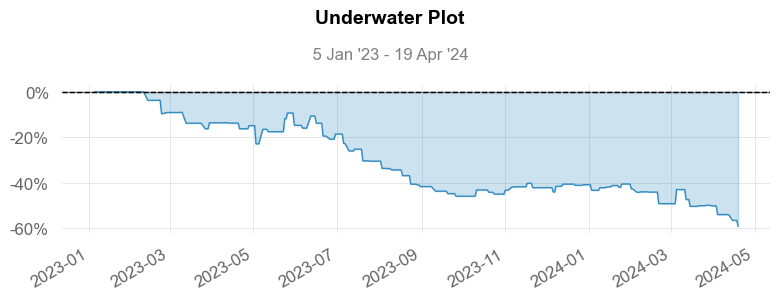

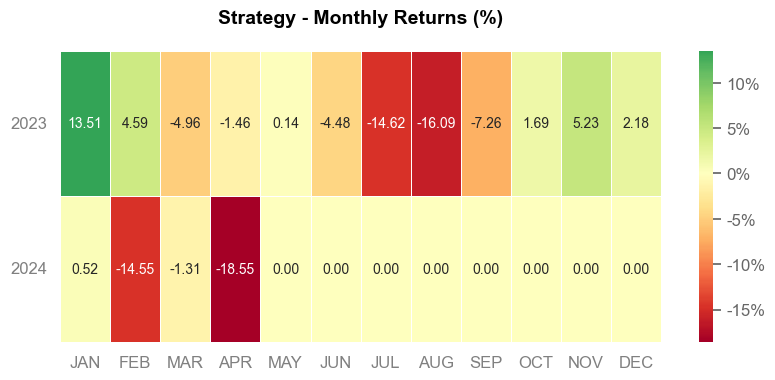

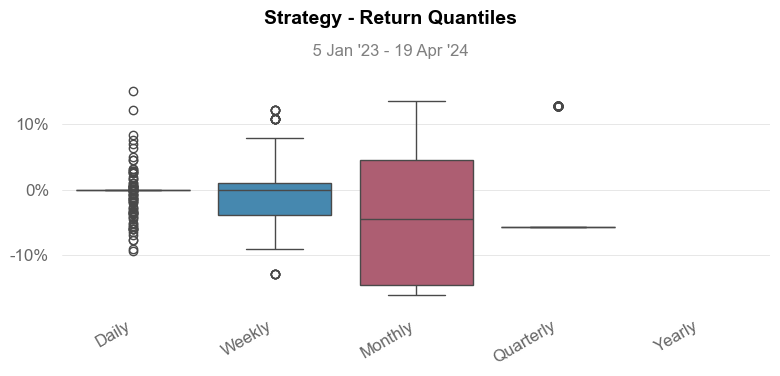

In [111]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

In [72]:
qs.reports.html(returns, output="quantstats-amd.html")

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 